In [1]:
import os, glob, sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.spatial import HalfspaceIntersection


sys.path.append('..')

from src.model import Model

In [2]:
%load_ext autoreload
%autoreload 2

# Эксперимент №1

In [32]:
mtx_A = np.array([[1, 1],
                  [0, 1]])
N = 6
n = 2

sys = Model(
    mtx_A, b=1., c=1.,
    n=n, N=N,
    vec_lambda=np.array([1, 1]),
    fi=1.,
    m_ksi=0.0,
    eps=0.25,
)


## Поверхности уровня 1

In [33]:
I = sys.cond_I(N+1)
I.A, I.b

(array([[ 1,  0],
        [ 0,  1],
        [-1,  0],
        [ 0, -1]]),
 array([1., 1., 1., 1.]))

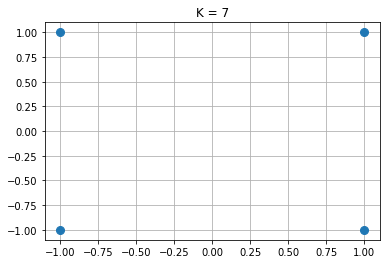

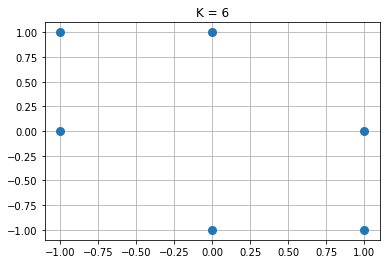

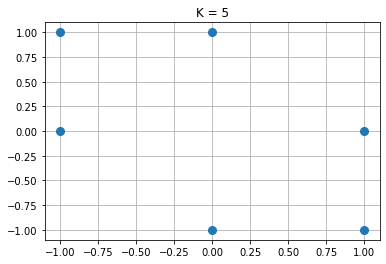

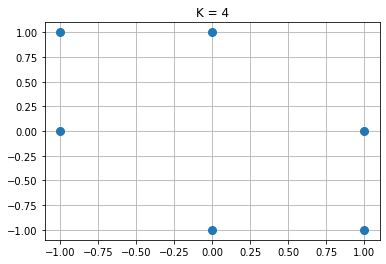

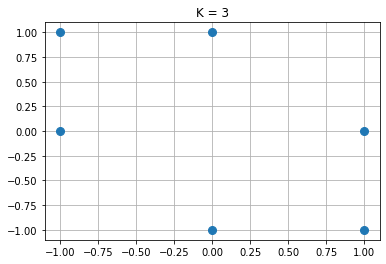

In [34]:
for k in [N+1, N, N-1, N-2, N-3]:
    
    I = sys.cond_I(k)
    x0 = np.array([0., 0.])
    
    G = np.column_stack([I.A, -I.b])
    hs = HalfspaceIntersection(G, x0)
    x, y = zip(*hs.intersections)
    plt.plot(x, y, 'o', markersize=8)
    plt.title(f"K = {k}")
    plt.grid()
    plt.show()


## Моделирование из одной точки

In [35]:
def modelling(sys, x0, random_seed=0):
    x_list, u_list = [x0], []

    np.random.seed(random_seed)
    ksi_list = np.random.uniform(
        low=sys.m_ksi-sys.eps, 
        high=sys.m_ksi + sys.eps, 
        size=sys.N + 1
    )

    for k in np.arange(sys.N + 1):
        u_k = sys.gamma(k, x_list[-1])
        x = sys.f(x_list[-1], u_k, ksi_list[k])        
        x_list.append(x)
        u_list.append(u_k)


    return np.array(x_list), np.array(u_list), ksi_list

def plot_modelling(sys, x_list, u_list, ksi_list):
    for i in np.arange(sys.n):
        plt.figure(figsize=(15, 4))
        plt.plot(x_list[:, i], "o-")
        plt.title(f"Динамика состояния системы по: X_{i + 1}")

        plt.hlines(sys.fi / sys.vec_lambda[i], 0, len(x_list[:, i]), linestyle="-")
        plt.hlines(-(sys.fi / sys.vec_lambda[i]), 0, len(x_list[:, i]), linestyle="-")
        plt.grid()

    plt.figure(figsize=(15, 4))
    plt.plot(u_list, "o-")
    plt.title(f"Управление: U")
    plt.grid()

    plt.figure(figsize=(15, 4))
    plt.plot(ksi_list, "o-")
    plt.title(f"Возмущение: Ksi")
    plt.grid()


In [37]:
x_list, u_list, ksi_list = modelling(sys, x0=np.array([1.3, 1.5]).reshape(-1, 1), random_seed=33)

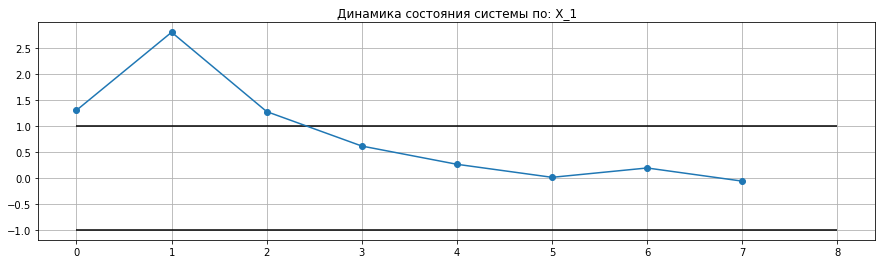

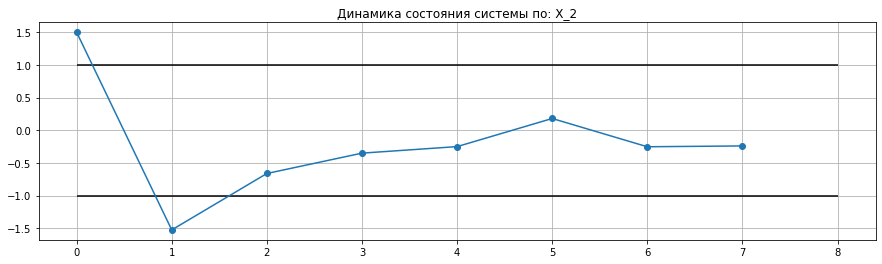

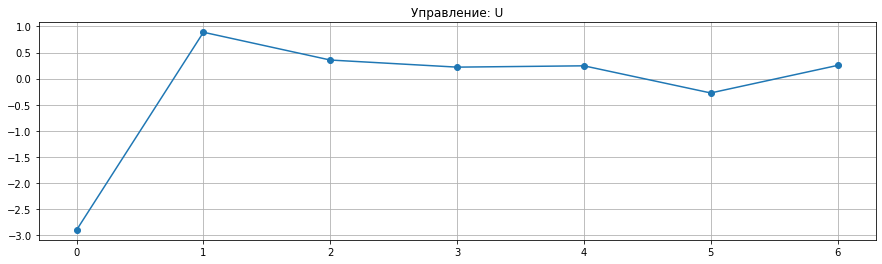

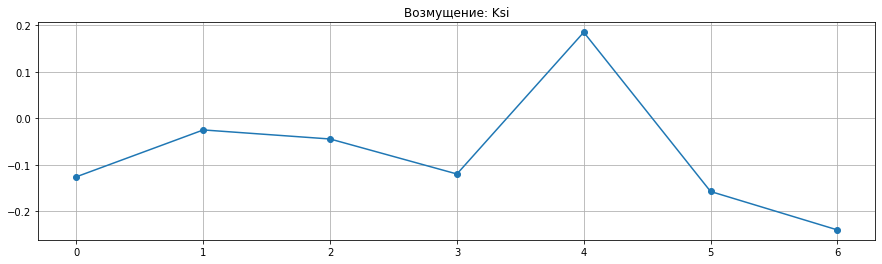

In [38]:
plot_modelling(sys, x_list, u_list, ksi_list)

In [41]:
# res = []
# xx1 = []
# xx2 = []

# for x1 in np.arange(-2,2,0.25):
#     for x2 in np.arange(-2,2,0.25):
#         x=np.array([x1, x2])
    
#         u = sys.gamma(k=0, x=x)
#         res.append(u)
#         xx1.append(x1)
#         xx2.append(x2)

In [40]:
# print('Lambda wave N+1')
# print(sys.mtx_Lambda_wave(N+1))
# print('Lambda N+1')
# print(sys.mtx_Lambda(N + 1))

# print('Lambda wave N')
# print(sys.mtx_Lambda_wave(N))
# print('Lambda N')
# print(sys.mtx_Lambda(N))

# print('Lambda wave N-1')
# print(sys.mtx_Lambda_wave(N-1))
# print('Lambda N-1')
# print(sys.mtx_Lambda(N - 1))

# print('Lambda wave N-2')
# print(sys.mtx_Lambda_wave(N - 2))

# print('Lambda N-2')
# print(sys.mtx_Lambda(N - 2))

# #sys.gamma(N - 1, np.array([0.25, 0.25]))
# u_k = sys.gamma(1, np.array([0.25, 0.25]))
# #u_k = sys.gamma(2, np.array([0.25, 0.25]))
# #u_k = sys.gamma(3, np.array([0.25, 0.25]))
